Hold-out Test MSE: 0.2733
Hold-out Test R² Score: 0.9665

Permutation Feature Importances:
             Feature  Importance
8        caffeine_mg    0.487123
2       stress_level    0.092955
0         work_hours    0.017797
4      support_level    0.009645
3   job_satisfaction    0.008352
1        sleep_hours    0.004264
6   exercise_minutes    0.002990
9  screen_time_hours    0.002469
5      exercise_days    0.002240
7        remote_work   -0.000051


/var/folders/1s/10qtqb6171xdtntxdftycm540000gn/T/ipykernel_15130/3283013123.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance, x="Importance", y="Feature", palette="viridis")


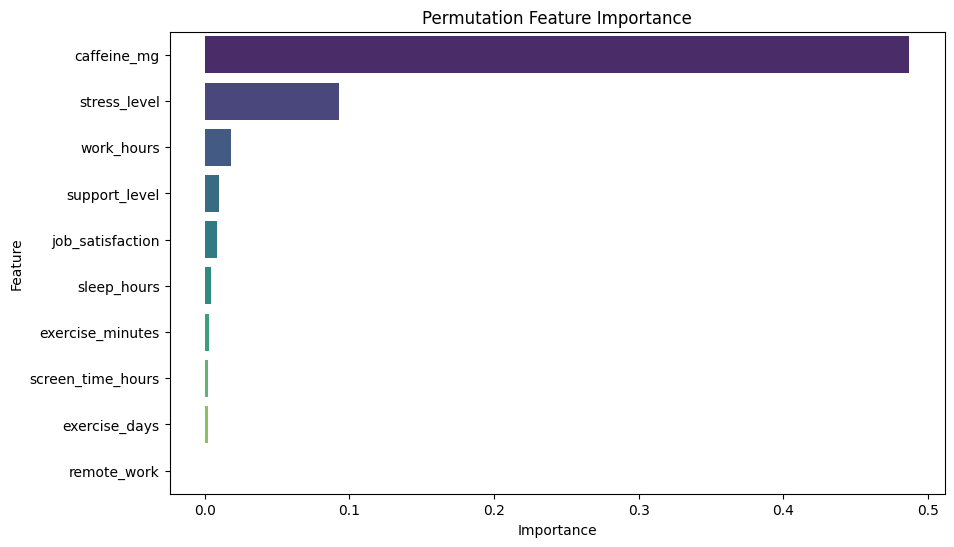

Predicted Burnout Score: 1.74


In [15]:
# Burnout Predictor with XGBoost + Scaler + Permutation Importance
# Jupyter Lab Script

# 1️⃣ Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import xgboost as xgb

# 2️⃣ Load Dataset
data = pd.read_csv("simulated_balanced_burnout_data.csv")

# Fix column names if there is a typo
data.rename(columns={'job_satisfication': 'job_satisfaction'}, inplace=True)

# Features & target
X = data.drop(columns=["burnout_score"])
y = data["burnout_score"]

# 3️⃣ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Scale Features ✅
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, "scaler.pkl")

# 5️⃣ Train XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# 6️⃣ Predictions & Evaluation
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Hold-out Test MSE: {mse:.4f}")
print(f"Hold-out Test R² Score: {r2:.4f}")

# 7️⃣ Permutation Feature Importance ✅ (fixes unrealistic caffeine dominance)
perm_result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_result.importances_mean
}).sort_values(by="Importance", ascending=False)

print("\nPermutation Feature Importances:")
print(perm_importance)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(data=perm_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Permutation Feature Importance")
plt.show()

# 8️⃣ Function to Predict Burnout for New Input
def predict_burnout(new_input_dict):
    """
    new_input_dict = {
        'work_hours': 35,
        'sleep_hours': 6,
        'stress_level': 3,
        'job_satisfaction': 7,
        'support_level': 8,
        'exercise_days': 4,
        'exercise_minutes': 40,
        'remote_work': 0,
        'caffeine_mg': 120,
        'screen_time_hours': 5
    }
    """
    new_df = pd.DataFrame([new_input_dict])
    # Scale using the saved scaler
    scaler = joblib.load("scaler.pkl")
    new_scaled = scaler.transform(new_df)
    prediction = model.predict(new_scaled)
    return prediction[0]

# 9️⃣ Test the Prediction Function
example_input = {
    'work_hours': 35,
    'sleep_hours': 6,
    'stress_level': 3,
    'job_satisfaction': 7,
    'support_level': 8,
    'exercise_days': 4,
    'exercise_minutes': 40,
    'remote_work': 0,
    'caffeine_mg': 120,
    'screen_time_hours': 5
}

predicted_score = predict_burnout(example_input)
print(f"Predicted Burnout Score: {predicted_score:.2f}")





In [13]:
import pickle

# Save the trained XGBoost model
with open("burnout_model.pkl", "wb") as f:
    pickle.dump(model, f)